In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import seaborn as sns
from scvi.external import CellAssign

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read dataset (as Normalized and log1p)

In [3]:
# bmcite = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\Stuart_bm\Stuart_bmcite_RNAassay_original.h5ad")
bmcite = sc.read_h5ad(dataset_dir / 'Stuart_bm/Stuart_bmcite_RNAassay_original.h5ad')
label = bmcite.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print(bmcite.shape)

all cell types: ['B cell', 'Mono/DC', 'NK', 'Progenitor cells', 'T cell']
(30672, 17009)


In [3]:
bmcite.obs.head()

,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight
a_AAACCTGAGCTTATCG-1,7546.0,2136,1350.0,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.482701
a_AAACCTGAGGTGGGTT-1,1029.0,437,2970.0,25,HumanHTO1,batch1,T cell,gdT,0.241789
a_AAACCTGAGTACATGA-1,1111.0,429,2474.0,23,HumanHTO5,batch1,T cell,CD4 Naive,0.507714
a_AAACCTGCAAACCTAC-1,2741.0,851,4799.0,25,HumanHTO3,batch1,T cell,CD4 Memory,0.431308
a_AAACCTGCAAGGTGTG-1,2099.0,843,5434.0,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.568508


## Read PreLect features

In [4]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\feature_selection_k3")
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/feature_selection_k3')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/feature_selection_k3')

hao_types = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']
features_genes_dict = {}
positive_features_genes_dict = {}
# Read features for each celltype
for celltype in hao_types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        # Sort the DataFrame: first by Tendency (descending), then by absolute value of Weight (descending)
        feature_df = feature_df.sort_values(by=['Tendency', 'Weight'], ascending=[False, False], key=lambda col: col.abs() if col.name == 'Weight' else col)
        # print(feature_df)
        features_genes_dict[celltype] = feature_df['Gene'].tolist() 
        positive_features_genes_dict[celltype] = feature_df[feature_df['Tendency'] == 1]['Gene'].tolist()
        # print(feature_df[feature_df['Tendency'] == 1]['Gene'].tolist())
        # break
    except:
        print('skipping:', celltype)
        continue

In [5]:
# count features for each cell type
print('All:')
for k, v in features_genes_dict.items():
    print(k, len(v))
print('Positive:')
for k, v in positive_features_genes_dict.items():
    print(k, len(v))

All:
B 19
CD4_T 201
CD8_T 23
DC 50
Mono 50
NK 33
other 5
other_T 247
Positive:
B 10
CD4_T 95
CD8_T 9
DC 23
Mono 20
NK 17
other 3
other_T 112


In [7]:
# Only select top 50 positive features from CD4_T and other_T
positive_features_genes_dict['CD4_T'] = positive_features_genes_dict['CD4_T'][:50]
positive_features_genes_dict['other_T'] = positive_features_genes_dict['other_T'][:50]
print(len(positive_features_genes_dict['CD4_T']))
print(len(positive_features_genes_dict['other_T']))

50
50


In [8]:
unique_genes = set()
for gene_list in positive_features_genes_dict.values():
    unique_genes.update(gene_list)
len(unique_genes)

165

In [10]:
# Create a new dataframe with genes as indexes and cell types as columns
marker_gene_mat = pd.DataFrame(0, index=list(unique_genes), columns=positive_features_genes_dict.keys())

# Iterate through the DEGs and update the new dataframe with 1 where there is a relationship
for celltype, gene_list in positive_features_genes_dict.items():
    for g in gene_list:
        marker_gene_mat.loc[g, celltype] = 1
marker_gene_mat


,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
CYBB,0,0,0,0,1,0,0,0
PRF1,0,0,0,0,0,1,0,0
FTL,0,0,0,0,1,0,0,0
TRGC1,0,0,0,0,0,0,0,1
PHACTR2,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
CD79A,1,0,0,0,0,0,0,0
TOMM7,0,1,0,0,0,0,0,0
CCL5,0,0,1,0,0,0,0,0
CD52,0,1,0,0,0,0,0,0


In [13]:
# Find marker genes
def rank_genes(adata, all_types):
    sc.tl.rank_genes_groups(adata, groupby='celltype.l1', n_genes=50, method='wilcoxon')

    # Get the top ranked genes for each celltype
    genes_dict = {}

    for celltype in all_types:
        genes_df = sc.get.rank_genes_groups_df(adata, group=celltype)
        genes = genes_df['names'].tolist()
        genes_dict[celltype] = genes
    
    return genes_dict
    

## Turn dataset back to raw counts
CellAssign takes raw counts matrix

In [14]:
# Take raw counts from layers['counts']
bmcite.X = bmcite.layers['counts']

In [15]:
# Briefly view adata.X
rows, cols = bmcite.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {bmcite.X[row, col]}')
    i += 1


Row 0, Column 23, Value 1.0
Row 0, Column 31, Value 1.0
Row 0, Column 49, Value 1.0
Row 0, Column 50, Value 1.0
Row 0, Column 58, Value 1.0
Row 0, Column 59, Value 2.0
Row 0, Column 75, Value 1.0
Row 0, Column 77, Value 1.0
Row 0, Column 78, Value 1.0
Row 0, Column 84, Value 19.0
Row 0, Column 88, Value 1.0
Row 0, Column 94, Value 1.0
Row 0, Column 101, Value 1.0
Row 0, Column 106, Value 1.0
Row 0, Column 108, Value 1.0
Row 0, Column 110, Value 7.0
Row 0, Column 136, Value 1.0
Row 0, Column 138, Value 2.0
Row 0, Column 147, Value 1.0
Row 0, Column 162, Value 1.0


In [16]:
# Set up size factor
lib_size = bmcite.X.sum(1)  # row sum of each cell
bmcite.obs["size_factor"] = lib_size / np.mean(lib_size)

In [17]:
bmcite.obs.head()

,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight,size_factor
a_AAACCTGAGCTTATCG-1,7546.0,2136,1350.0,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.482701,2.551680
a_AAACCTGAGGTGGGTT-1,1029.0,437,2970.0,25,HumanHTO1,batch1,T cell,gdT,0.241789,0.347956
a_AAACCTGAGTACATGA-1,1111.0,429,2474.0,23,HumanHTO5,batch1,T cell,CD4 Naive,0.507714,0.375685
a_AAACCTGCAAACCTAC-1,2741.0,851,4799.0,25,HumanHTO3,batch1,T cell,CD4 Memory,0.431308,0.926869
a_AAACCTGCAAGGTGTG-1,2099.0,843,5434.0,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.568508,0.709777


## Subset dataset to only the marker genes

In [18]:
# It is critical that gene expression data containing only marker genes is used as input to cellassign.
a = bmcite.var_names
b = marker_gene_mat.index
inter = a.intersection(b)
print('Intersection:', len(inter))
common_genes = [i in b for i in a]  # a list of bools
bmcite_subset = bmcite[:, common_genes].copy()  # only select common_genes columns
print(bmcite_subset.shape)

Intersection: 162
(30672, 162)


In [19]:
# Sets up the AnnData object for this model.
scvi.external.CellAssign.setup_anndata(bmcite_subset, size_factor_key="size_factor")

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scvi\data\fields\_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [20]:
# Train CellAssign
import torch
torch.set_float32_matmul_precision('high')
model = CellAssign(bmcite_subset, marker_gene_mat)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 282/400:  70%|███████   | 282/400 [02:55<01:13,  1.61it/s, v_num=1, train_loss_step=155, train_loss_epoch=154]
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 153.607. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

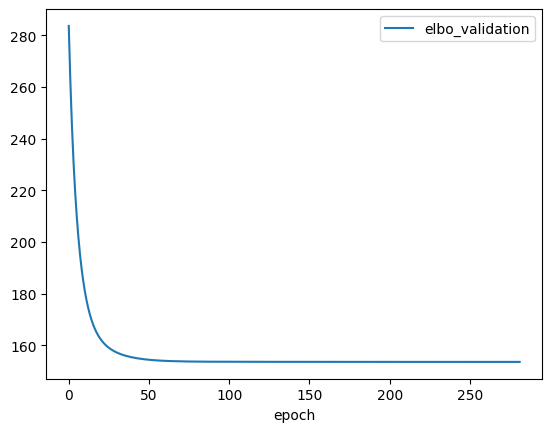

In [21]:
model.history["elbo_validation"].plot()

In [22]:
predictions = model.predict()

In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\Stuart_bm_annotate\Stuart_CellAssign')
os.chdir(source_code_dir / r'Stuart_bm_annotate\Stuart_CellAssign')
predictions.index = bmcite.obs_names
predictions.to_csv('CellAssign_pred_Stuart_L1_PreLect_v2.csv')

In [24]:
largest_values = []
largest_columns = []
assignments = []
for index, row in predictions.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
for celltype in hao_types:
    print(sum(result_df['Assignment'] == celltype))


3906
7
14280
862
7727
1851
2038
1


In [25]:
hao_types

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

In [26]:
os.getcwd()

'C:\\Users\\evanlee\\Documents\\GitHub\\EvanPys\\Progress\\PBMC_Hao_batch_noZ\\Level1\\feature_selection_k3'

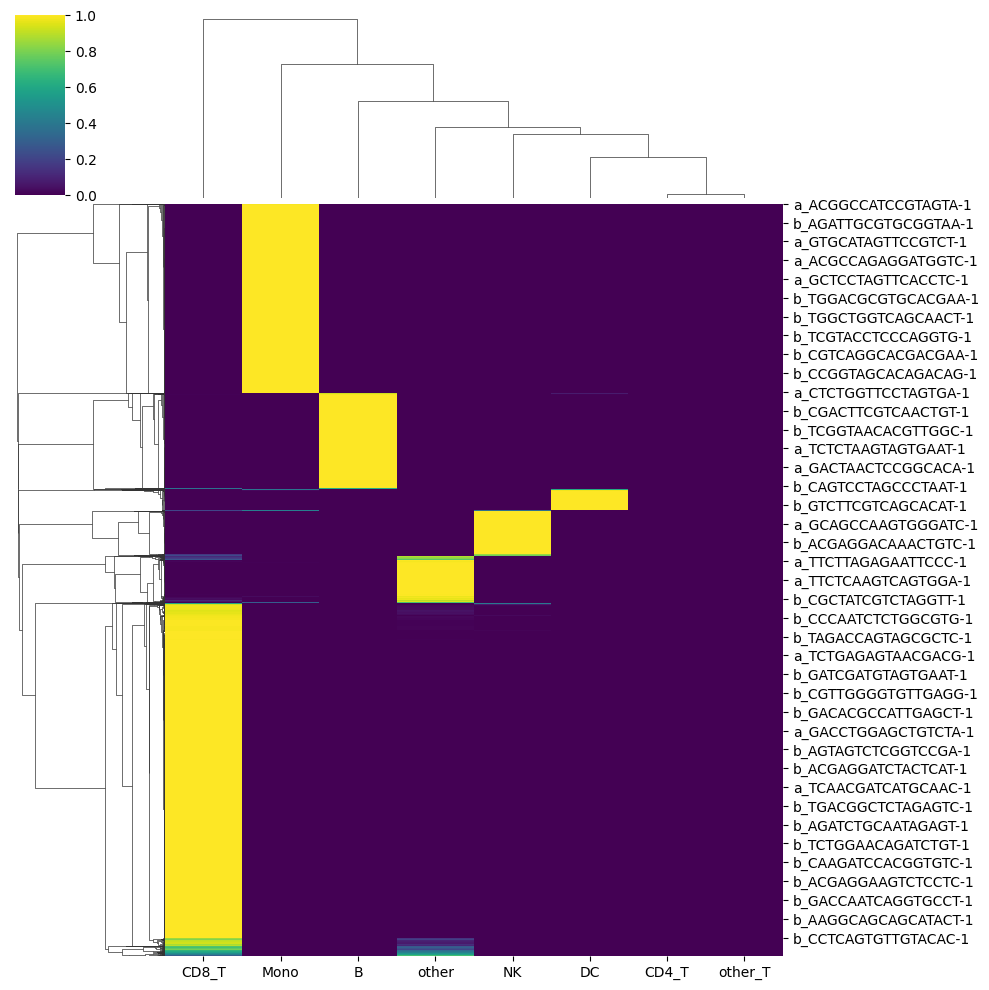

In [27]:
import sys
sys.setrecursionlimit(100000)
sns.clustermap(predictions, cmap="viridis")